In [13]:
from cv2 import aruco
import cv2
import numpy as np
import matplotlib.pyplot as plt
import msgpack as mp
import msgpack_numpy as mpn
import os

from tqdm import tqdm
import csv
import pandas as pd
import polars as pl

In [3]:
_pth = os.getcwd()
_pth = os.path.dirname(_pth)
_parent_folder = "cam_june_22_2023"
_calib_folder_name = "calibration_00"

_folder_name = "sk40_30_4_random_slow_00"
# _folder_name = "board"

_base_pth = os.path.join(_pth,"recorded_data",_parent_folder)

_webcam_calib_folder = os.path.join(_pth,"recorded_data",_parent_folder,_calib_folder_name)
_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_calib_pth = os.path.join( _webcam_calib_folder, "webcam_calibration.msgpack")

with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]

_webcam_cam_mat

array([[671.25534529,   0.        , 678.00736213],
       [  0.        , 692.23316717, 443.37269229],
       [  0.        ,   0.        ,   1.        ]])

In [4]:
ARUCO_PARAMETERS = aruco.DetectorParameters_create()
ARUCO_DICT = aruco.Dictionary_get(aruco.DICT_ARUCO_ORIGINAL)
markerLength = 0.04
markerSeparation = 0.01

board = aruco.GridBoard_create(
        markersX=1,
        markersY=1,
        markerLength=markerLength,
        markerSeparation=markerSeparation,
        dictionary=ARUCO_DICT)

In [5]:
_video_pth = os.path.join(_base_pth,_folder_name,"webcam_color.msgpack")
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)

default_ids = [0, 49, 80]

data = {"frame_id":[],"marker_ids":[], "corners":[], "tvec":[], "rvec":[]}

counter = 0

for _frame in tqdm(_video_data):

    shape = _frame.shape
    gray = cv2.cvtColor(_frame, cv2.COLOR_BGR2GRAY)
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, ARUCO_DICT, parameters=ARUCO_PARAMETERS)

    corners, ids, rejectedImgPoints, recoveredIds = aruco.refineDetectedMarkers(
        image = gray,
        board = board,
        detectedCorners = corners,
        detectedIds = ids,
        rejectedCorners = rejectedImgPoints,
        cameraMatrix = _webcam_cam_mat,
        distCoeffs = _webcam_dist)

    rotation_vectors, translation_vectors, _ = aruco.estimatePoseSingleMarkers(corners, 0.04, _webcam_cam_mat, _webcam_dist)

    if ids is None:
        data["frame_id"].append(counter)
        data["marker_ids"].append(None)
        data["corners"].append(None)
        data["tvec"].append(None)
        data["rvec"].append(None)

    if ids is not None:
        data["frame_id"].append(counter)
        data["marker_ids"].append(ids)
        data["corners"].append(corners)
        data["tvec"].append(translation_vectors)
        data["rvec"].append(rotation_vectors)

    counter+=1


_video_file.close()

892it [00:17, 51.19it/s]


In [6]:
coordinate = {"0":{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              "49":{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              "80":{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]}}

doesnt_exist = [] # list of ids that doesnt exist in a frame

for i in range(len(data["frame_id"])):
    if data["marker_ids"][i] is not None:

        if default_ids[0] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[0])
        if default_ids[1] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[1])
        if default_ids[2] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[2])

        for j in range(len(data["marker_ids"][i])):
            if data["marker_ids"][i][j] in default_ids:
                coordinate[str(data["marker_ids"][i][j][0])]["x"].append(data["tvec"][i][j][0][0])
                coordinate[str(data["marker_ids"][i][j][0])]["y"].append(data["tvec"][i][j][0][1])
                coordinate[str(data["marker_ids"][i][j][0])]["z"].append(data["tvec"][i][j][0][2])
                coordinate[str(data["marker_ids"][i][j][0])]["rx"].append(data["rvec"][i][j][0][0])
                coordinate[str(data["marker_ids"][i][j][0])]["ry"].append(data["rvec"][i][j][0][1])
                coordinate[str(data["marker_ids"][i][j][0])]["rz"].append(data["rvec"][i][j][0][2])
        for k in doesnt_exist:
            coordinate[str(k)]["x"].append(np.nan)
            coordinate[str(k)]["y"].append(np.nan)
            coordinate[str(k)]["z"].append(np.nan)
            coordinate[str(k)]["rx"].append(np.nan)
            coordinate[str(k)]["ry"].append(np.nan)
            coordinate[str(k)]["rz"].append(np.nan)
        doesnt_exist = []
    else:
        for k in default_ids:
            coordinate[str(k)]["x"].append(np.nan)
            coordinate[str(k)]["y"].append(np.nan)
            coordinate[str(k)]["z"].append(np.nan)
            coordinate[str(k)]["rx"].append(np.nan)
            coordinate[str(k)]["ry"].append(np.nan)
            coordinate[str(k)]["rz"].append(np.nan)

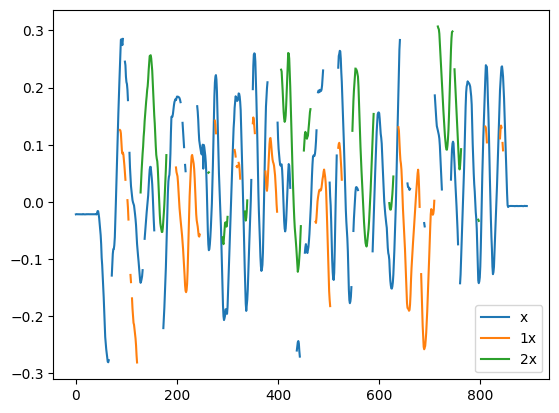

In [7]:
plt.plot(coordinate["0"]["x"], label="x")
plt.plot(coordinate["49"]["x"], label="1x")
plt.plot(coordinate["80"]["x"], label="2x")
plt.legend()

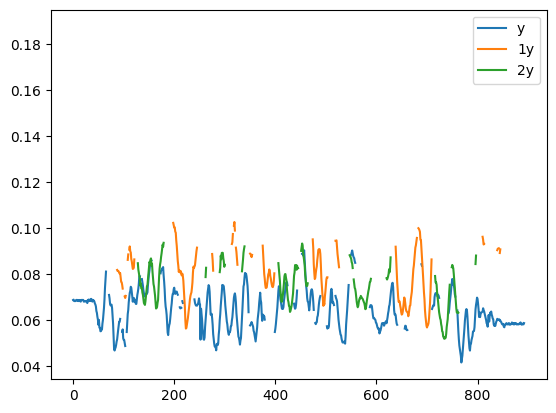

In [8]:
plt.plot(coordinate["0"]["y"], label="y")
plt.plot(coordinate["49"]["y"], label="1y")
plt.plot(coordinate["80"]["y"], label="2y")
plt.legend()

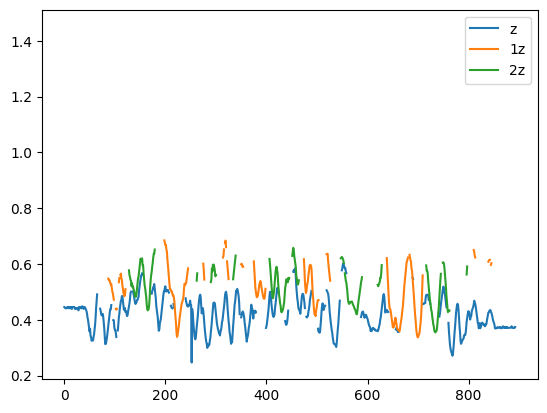

In [9]:
plt.plot(coordinate["0"]["z"], label="z")
plt.plot(coordinate["49"]["z"], label="1z")
plt.plot(coordinate["80"]["z"], label="2z")
plt.legend()

In [10]:
rmat = []
for i in range(len(coordinate["0"]["x"])):
    rotation_vectors = np.array([coordinate["0"]["rx"][i], coordinate["0"]["ry"][i], coordinate["0"]["rz"][i]])
    rotation_matrix = cv2.Rodrigues(rotation_vectors)[0]
    rmat.append(rotation_matrix)

In [14]:
df_0 = pd.DataFrame({"x":coordinate["0"]["x"], "y":coordinate["0"]["y"], "z":coordinate["0"]["z"]})
df_0 = pl.from_pandas(df_0)

In [26]:
tcoor = {"x":[], "y":[], "z":[]}
for i in range(len(coordinate["0"]["x"])):
    val = rmat[0].T @ (df_0[i].to_numpy() - df_0[0].to_numpy()).T

    if val is None:
        x = np.nan
        y = np.nan
        z = np.nan
    else:
        x = val[0]
        y = val[1]
        z = val[2]
    tcoor["x"].append(x)
    tcoor["y"].append(y)
    tcoor["z"].append(z)

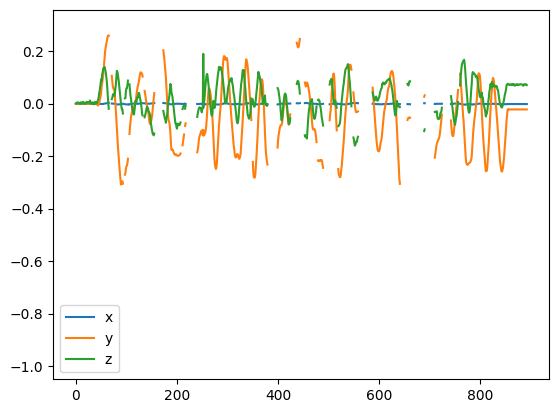

In [27]:
plt.plot(tcoor["x"], label="x")
plt.plot(tcoor["y"], label="y")
plt.plot(tcoor["z"], label="z")
plt.legend()

In [28]:
df_49 = pd.DataFrame({"x":coordinate["49"]["x"], "y":coordinate["49"]["y"], "z":coordinate["49"]["z"]})
df_49 = pl.from_pandas(df_49)

In [29]:
tcoor_49 = {"x":[], "y":[], "z":[]}
for i in range(len(coordinate["49"]["x"])):
    val = rmat[0].T @ (df_49[i].to_numpy() - df_0[0].to_numpy()).T

    if val is None:
        x = np.nan
        y = np.nan
        z = np.nan
    else:
        x = val[0]
        y = val[1]
        z = val[2]
    tcoor_49["x"].append(x)
    tcoor_49["y"].append(y)
    tcoor_49["z"].append(z)

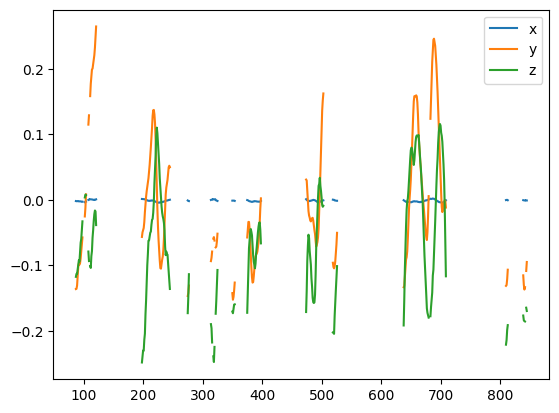

In [31]:
plt.plot(tcoor_49["x"], label="x")
plt.plot(tcoor_49["y"], label="y")
plt.plot(tcoor_49["z"], label="z")
plt.legend()

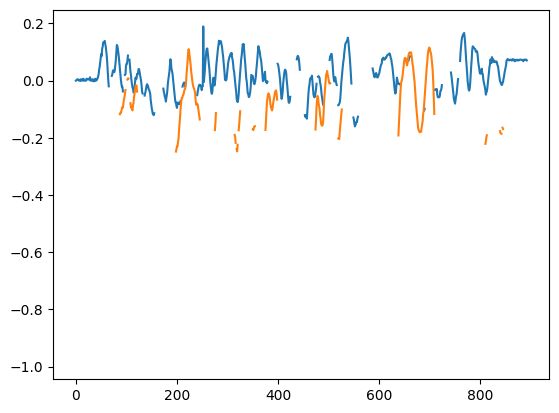

In [34]:
plt.plot(tcoor["z"], label="x")
plt.plot(tcoor_49["z"], label="1x")